In [4]:
import pandas as pd

# Step 1: Read the CSV file
df = pd.read_csv("pond_data_interpolated_with_indices (1).csv")

# Step 2: Convert the date column correctly
df["Date of Data Collection"] = pd.to_datetime(df["Date of Data Collection"], dayfirst=True, errors="coerce")

# Step 3: Melt the data for easy plotting (tidy format)
melted = df.melt(
    id_vars="Date of Data Collection",
    value_vars=["Dissolved Oxygen (mg/L)", "Ammonia (mg/L)", "pH"],
    var_name="Parameter",
    value_name="Value"
)

# (optional) Check for any dates that failed conversion
print(df["Date of Data Collection"].isna().sum(), "dates could not be parsed")


0 dates could not be parsed


Columns in dataset: ['Date of Data Collection', 'Pond ID', 'Latitude', 'Longitude', 'Dissolved Oxygen (mg/L)', 'pH', 'Ammonia (mg/L)', 'Turbidity (cm)', 'Temperature (°C)', 'Pond area \n(acres)', 'B1', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'NDVI', 'NDWI', 'MNDWI', 'NDCI']
  Date of Data Collection Pond ID   Latitude  Longitude  \
0              12-07-2021  1_58_2  16.730750  81.027281   
1              12-07-2021  1_58_2  16.730750  81.027281   
2              14-07-2021  2_33_2  14.496684  80.143511   
3              18-07-2021  2_11_1  14.474286  80.151311   
4              18-07-2021  2_60_1  14.472638  80.150407   

   Dissolved Oxygen (mg/L)       pH  Ammonia (mg/L)  Turbidity (cm)  \
0                 6.600000  8.21000        0.142623       28.490865   
1                 6.200000  8.13000        0.142623       28.490865   
2                 6.446384  8.19971        0.142623       29.800000   
3                 6.446384  8.19971        0.142623      

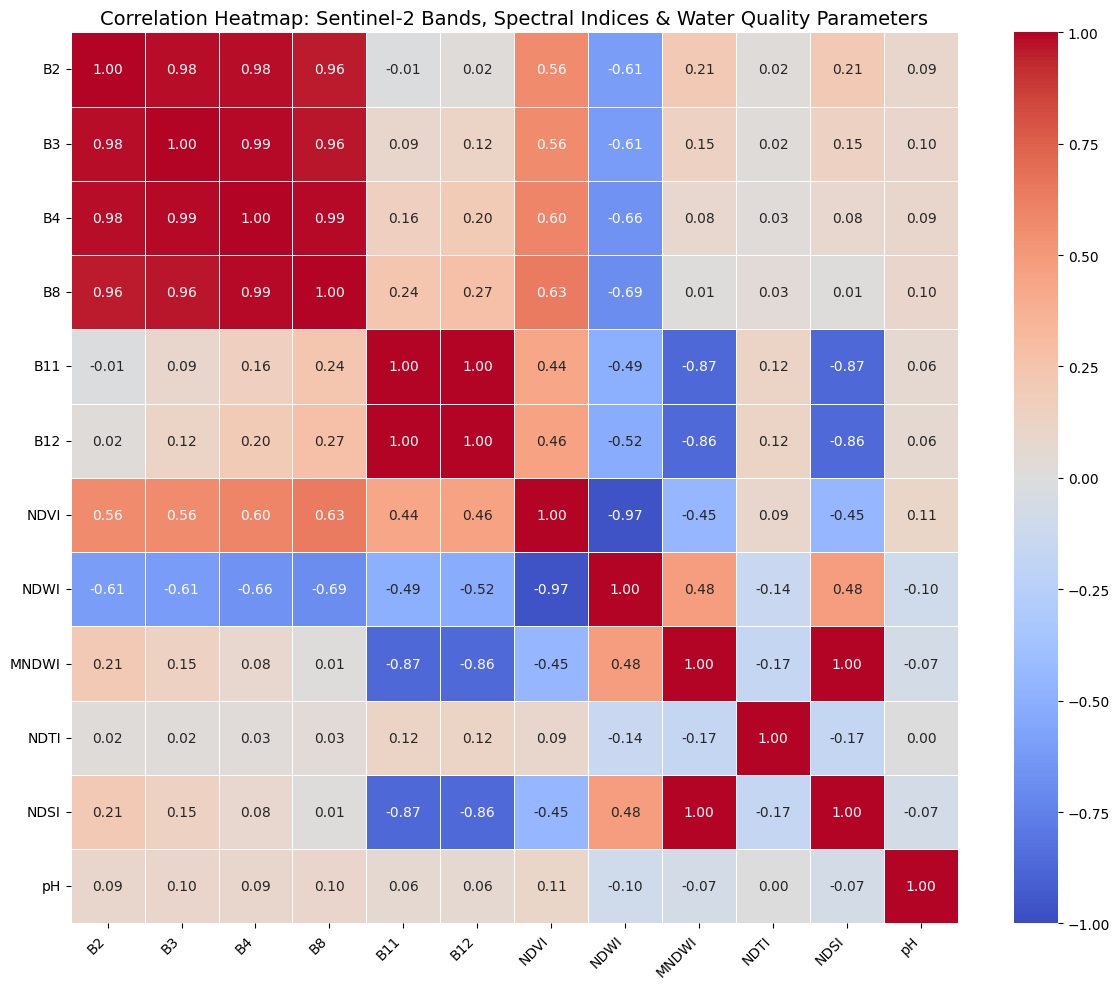

In [5]:
# =========================================
# Correlation Heatmap: Sentinel-2 Bands, Indices & Water Quality Parameters
# =========================================

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------
# 1. Load your dataset
# -----------------------------------------
# Replace with your CSV filename
df = pd.read_csv("pond_data_interpolated_with_indices (1).csv")

# Check your data columns
print("Columns in dataset:", df.columns.tolist())
print(df.head())

# -----------------------------------------
# 2. Compute Spectral Indices
# -----------------------------------------
# Handle divide-by-zero errors safely
def safe_divide(a, b):
    return np.where((a + b) == 0, np.nan, (a - b) / (a + b))

df["NDVI"] = safe_divide(df["B8"], df["B4"])      # Normalized Difference Vegetation Index
df["NDWI"] = safe_divide(df["B3"], df["B8"])      # Normalized Difference Water Index
df["MNDWI"] = safe_divide(df["B3"], df["B11"])    # Modified NDWI (Green vs SWIR1)
df["NDTI"] = safe_divide(df["B11"], df["B12"])    # Normalized Difference Turbidity Index
df["NDSI"] = safe_divide(df["B3"], df["B11"])     # Normalized Difference Snow/Water Index

# -----------------------------------------
# 3. Select relevant columns
# -----------------------------------------
# Adjust the water quality parameter names as per your dataset
bands_and_indices = ["B2", "B3", "B4", "B8", "B11", "B12", "NDVI", "NDWI", "MNDWI", "NDTI", "NDSI"]
water_quality = ["Chlorophyll_a", "Turbidity", "TSS", "pH", "DO"]  # Example parameters

selected_columns = bands_and_indices + water_quality

# Keep only existing columns
selected_columns = [col for col in selected_columns if col in df.columns]
data = df[selected_columns]

# -----------------------------------------
# 4. Compute correlation matrix
# -----------------------------------------
corr_matrix = data.corr(method='pearson')

# -----------------------------------------
# 5. Plot correlation heatmap
# -----------------------------------------
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Sentinel-2 Bands, Spectral Indices & Water Quality Parameters", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor  # or RandomForestClassifier if classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Load your data  
# Assume you have a DataFrame `df` with spectral predictor columns + target columns ammonia and ph
df = pd.read_csv("pond_data_interpolated_with_indices (1).csv")

# 2. Choose predictors & target(s)
spectral_cols = [c for c in df.columns if c.startswith("band_")]  # e.g., band_B2, band_B3, etc.
X = df[spectral_cols]
y_ammonia = df["Ammonia (mg/L)"]    # target 1
y_ph = df["pH"]              # target 2 (if you want separate models)

# 3. Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_ammonia, test_size=0.2, random_state=42)

# 4. Fit Random Forest model
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# 5. Get built‐in feature importance (Gini/impurity‐based)  
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=spectral_cols).sort_values(ascending=False)

# 6. Plot top features
plt.figure(figsize=(8,6))
feat_imp.head(10).plot(kind="barh")
plt.xlabel("Feature importance (mean decrease impurity)")
plt.ylabel("Spectral band predictor")
plt.title("Top 10 spectral predictors for ammonia")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 7. Optionally, output the importance table
print(feat_imp.head(20))

# 8. If you want to do the same for pH:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y_ph, test_size=0.2, random_state=42)
rf2 = RandomForestRegressor(n_estimators=200, random_state=42)
rf2.fit(X_train2, y_train2)
imp2 = pd.Series(rf2.feature_importances_, index=spectral_cols).sort_values(ascending=False)
print("Top predictors for pH:")
print(imp2.head(20))


ValueError: at least one array or dtype is required

R² Score: -0.064
RMSE: 0.114

Sample Comparison:
   Actual_Ammonia  Predicted_Ammonia
0        0.160000           0.114002
1        0.310000           0.100347
2        0.000000           0.136592
3        0.142623           0.114002
4        0.020000           0.102194
5        0.050000           0.109432
6        0.040000           0.113834
7        0.000000           0.070197
8        0.090000           0.129903
9        0.142623           0.110247


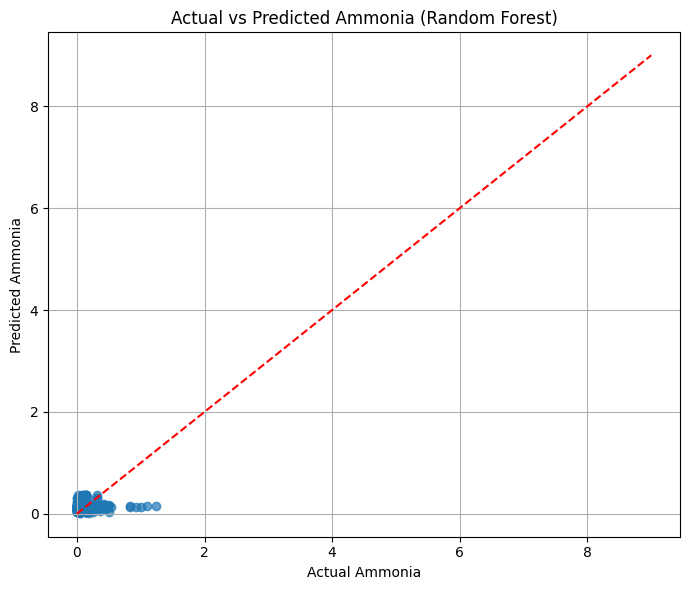

Results saved to Ammonia_Predicted_vs_Actual.csv


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# 1️⃣ Load your dataset
df = pd.read_csv("pond_data_interpolated_with_indices (1).csv")   # <-- change filename here

# Example: choose predictor columns (bands, indices, water parameters)
# Adjust this list depending on your dataset column names
feature_cols = [c for c in df.columns if c.startswith("band_") or c in ["pH", "temperature", "turbidity", "EC", "DO"]]

X = df[feature_cols]
y = df["Ammonia (mg/L)"]   # <-- ensure this matches your ammonia column name

# 2️⃣ Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3️⃣ Train Random Forest Model
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# 4️⃣ Predict ammonia values
y_pred = rf.predict(X_test)

# 5️⃣ Evaluate Performance
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

# 6️⃣ Create comparison table
comparison_df = pd.DataFrame({
    "Actual_Ammonia": y_test.values,
    "Predicted_Ammonia": y_pred
})
print("\nSample Comparison:")
print(comparison_df.head(10))

# 7️⃣ Plot Actual vs Predicted
plt.figure(figsize=(7,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # reference line
plt.xlabel("Actual Ammonia")
plt.ylabel("Predicted Ammonia")
plt.title("Actual vs Predicted Ammonia (Random Forest)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 8️⃣ Save results
comparison_df.to_csv("Ammonia_Predicted_vs_Actual.csv", index=False)
print("Results saved to Ammonia_Predicted_vs_Actual.csv")


R² Score: -0.06406154899015215
RMSE: 0.11397541805121794
   Actual_Ammonia  Predicted_Ammonia
0        0.160000           0.114002
1        0.310000           0.100347
2        0.000000           0.136592
3        0.142623           0.114002
4        0.020000           0.102194


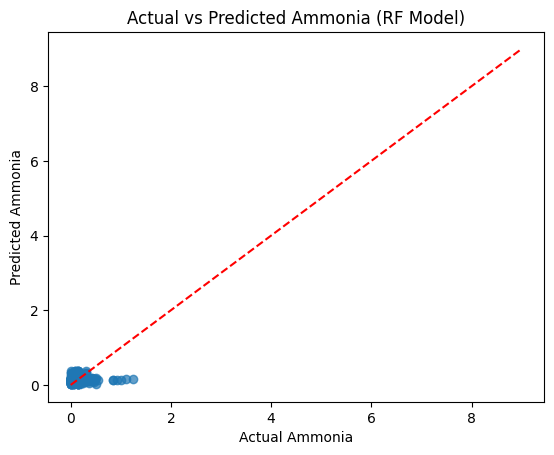

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

df = pd.read_csv("pond_data_interpolated_with_indices (1).csv")

# Remove any date columns
df = df.drop(columns=[c for c in df.columns if 'date' in c.lower() or 'Date' in c])

# Ensure Ammonia is numeric
df["Ammonia (mg/L)"] = pd.to_numeric(df["Ammonia (mg/L)"], errors='coerce')

# Select feature columns
feature_cols = [c for c in df.columns if c.startswith("band_") or c in ["pH", "temperature", "turbidity", "EC", "DO"]]
X = df[feature_cols]
y = df["Ammonia (mg/L)"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Comparison table
comparison_df = pd.DataFrame({"Actual_Ammonia": y_test.values, "Predicted_Ammonia": y_pred})
print(comparison_df.head())

# Plot
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Ammonia")
plt.ylabel("Predicted Ammonia")
plt.title("Actual vs Predicted Ammonia (RF Model)")
plt.show()


R² Score: 0.501
RMSE: 0.209

Sample comparison:
   Actual_pH  Predicted_pH
0       7.90      7.902500
1       8.15      8.127400
2       8.30      8.197743
3       7.90      8.305899
4       8.03      8.219347
5       7.92      8.032649
6       8.00      8.248649
7       7.72      7.881800
8       8.17      7.948600
9       8.13      8.365000


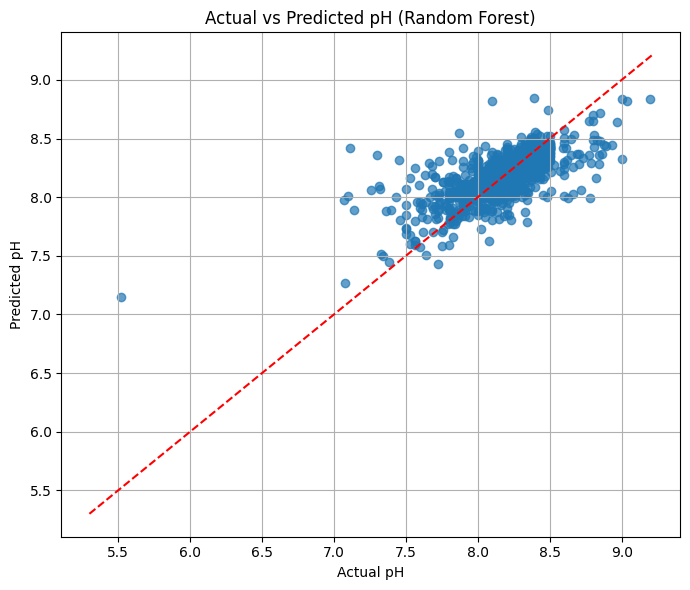

In [6]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# 1️⃣ Load dataset
df = pd.read_csv("pond_data_interpolated_with_indices (1).csv")

# 2️⃣ Convert pH to numeric
df["pH"] = pd.to_numeric(df["pH"], errors="coerce")

# 3️⃣ Drop date or non-numeric columns
df = df.select_dtypes(include=[np.number])   # ✅ Keep only numeric columns

# 4️⃣ Drop rows where pH is missing
df = df.dropna(subset=["pH"])

# 5️⃣ Define X (features) and y (target)
# Remove pH from feature list
X = df.drop(columns=["pH"])
y = df["pH"]

# 6️⃣ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7️⃣ Train Random Forest Model
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# 8️⃣ Predict pH
y_pred = rf.predict(X_test)

# 9️⃣ Evaluate Model
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

# 🔟 Comparison table
comparison_df = pd.DataFrame({
    "Actual_pH": y_test.values,
    "Predicted_pH": y_pred
})
print("\nSample comparison:")
print(comparison_df.head(10))

# 1️⃣1️⃣ Scatter Plot
plt.figure(figsize=(7,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Reference Line
plt.xlabel("Actual pH")
plt.ylabel("Predicted pH")
plt.title("Actual vs Predicted pH (Random Forest)")
plt.grid(True)
plt.tight_layout()
plt.show()

# (Optional) Save results
#comparison_df.to_csv("pH_Predicted_vs_Actual.csv", index=False)



Model Performance for DO
R² Score: 0.492
RMSE: 2.991
MAE: 1.343

Sample Comparison:
   Actual_DO  Predicted_DO
0        3.8       3.68200
1        1.9       3.44705
2       10.9       8.57745
3        5.1       8.16920
4        9.1       5.27950


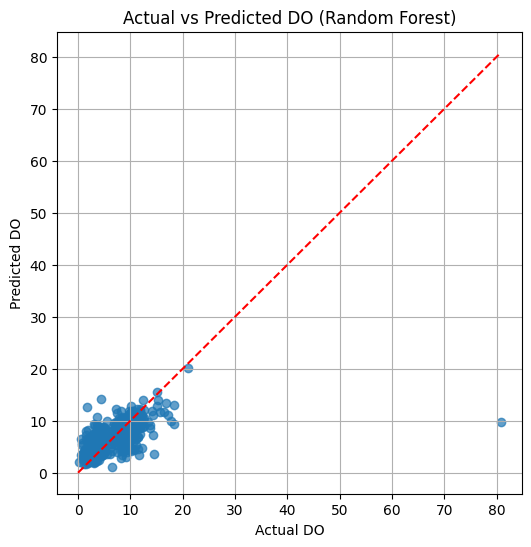


Model Performance for Ammonia
R² Score: -0.526
RMSE: 0.136
MAE: 0.048

Sample Comparison:
   Actual_Ammonia  Predicted_Ammonia
0        0.160000           0.065639
1        0.310000           0.147054
2        0.000000           0.064338
3        0.142623           0.337019
4        0.020000           0.086694


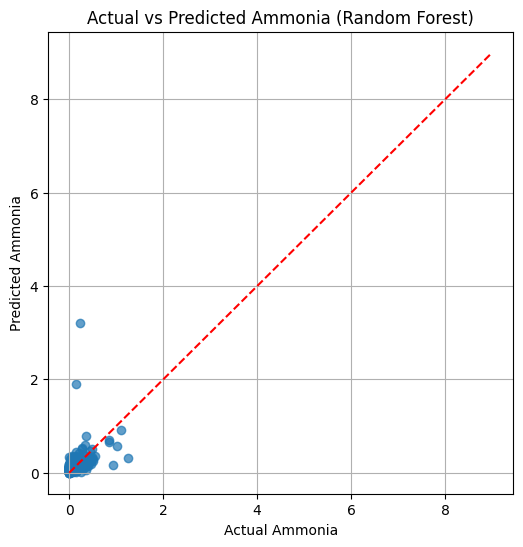


Model Performance for pH
R² Score: 0.501
RMSE: 0.209
MAE: 0.138

Sample Comparison:
   Actual_pH  Predicted_pH
0       7.90      7.902500
1       8.15      8.127400
2       8.30      8.197743
3       7.90      8.305899
4       8.03      8.219347


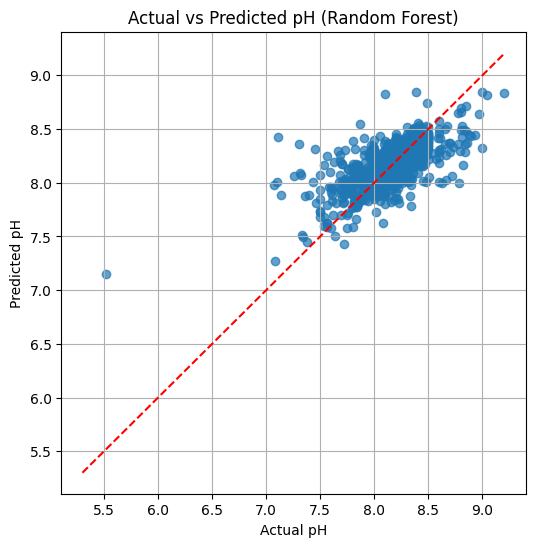

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 1️⃣ Load dataset
df = pd.read_csv("pond_data_interpolated_with_indices (1).csv")

# 2️⃣ Convert targets to numeric
for col in ["Dissolved Oxygen (mg/L)", "Ammonia (mg/L)", "pH"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 3️⃣ Keep only numeric columns
df_numeric = df.select_dtypes(include=[np.number])

# 4️⃣ Define target variables
targets = {
    "Dissolved Oxygen (mg/L)": "DO",
    "Ammonia (mg/L)": "Ammonia",
    "pH": "pH"
}

# 5️⃣ Loop through each target
for target_col, label in targets.items():

    print("\n============================")
    print(f"Model Performance for {label}")
    print("============================")

    # Remove rows with missing target
    temp = df_numeric.dropna(subset=[target_col])

    # Features = all numeric except target
    X = temp.drop(columns=[target_col])
    y = temp[target_col]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train Random Forest
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print(f"R² Score: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}")

    # Comparison table
    comparison_df = pd.DataFrame({
        f"Actual_{label}": y_test.values,
        f"Predicted_{label}": y_pred
    })

    print("\nSample Comparison:")
    print(comparison_df.head(5))

    # Scatter Plot
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.xlabel(f"Actual {label}")
    plt.ylabel(f"Predicted {label}")
    plt.title(f"Actual vs Predicted {label} (Random Forest)")
    plt.grid(True)
    plt.show()



 Feature Importance for DO

Top 10 Most Influential Predictors:
                Feature  Importance
2                    pH    0.298559
3        Ammonia (mg/L)    0.254308
1             Longitude    0.073022
20                MNDWI    0.046000
0              Latitude    0.043817
21                 NDCI    0.041715
4        Turbidity (cm)    0.040154
5   Pond area \n(acres)    0.033442
17                   B9    0.029105
19                 NDWI    0.023893


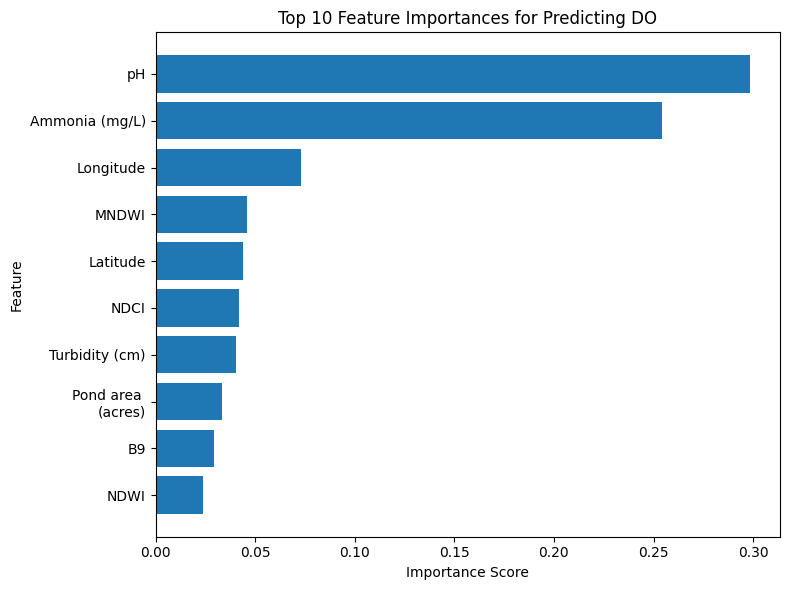


 Feature Importance for Ammonia

Top 10 Most Influential Predictors:
                    Feature  Importance
4            Turbidity (cm)    0.269624
2   Dissolved Oxygen (mg/L)    0.098088
1                 Longitude    0.097729
5       Pond area \n(acres)    0.088271
3                        pH    0.076314
0                  Latitude    0.047260
19                     NDWI    0.042144
20                    MNDWI    0.037332
17                       B9    0.026057
18                     NDVI    0.025158


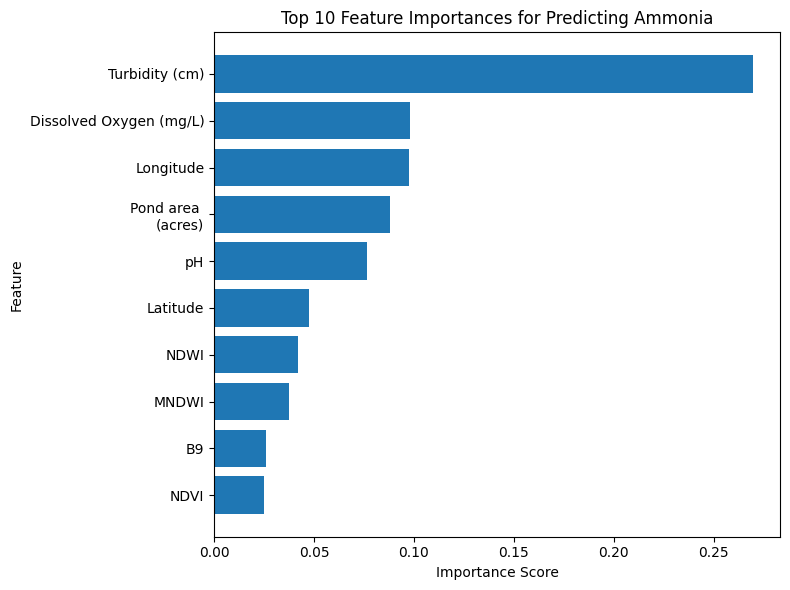


 Feature Importance for pH

Top 10 Most Influential Predictors:
                    Feature  Importance
2   Dissolved Oxygen (mg/L)    0.286395
1                 Longitude    0.099076
4            Turbidity (cm)    0.091573
5       Pond area \n(acres)    0.056668
21                     NDCI    0.053216
0                  Latitude    0.050641
3            Ammonia (mg/L)    0.040688
20                    MNDWI    0.040067
17                       B9    0.039516
18                     NDVI    0.038145


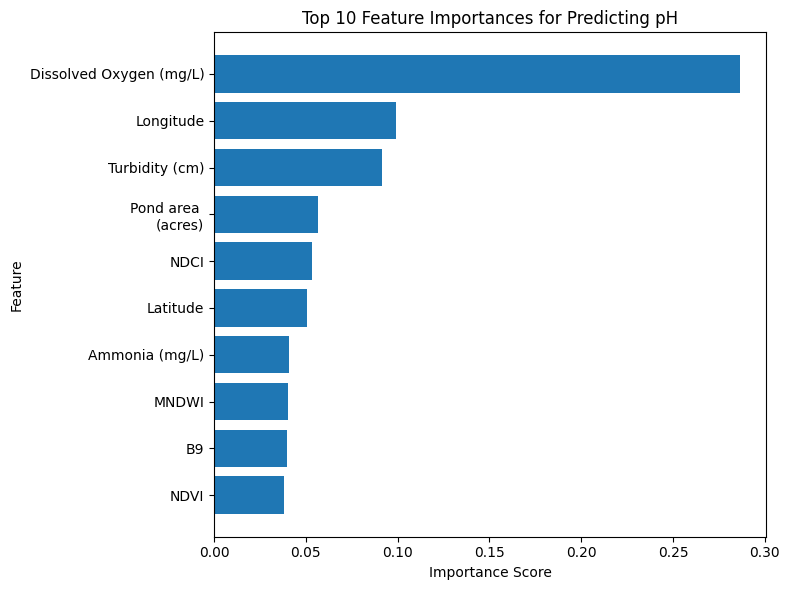

In [8]:
# Feature Importance Analysis from Random Forest Models for DO, Ammonia, and pH

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 1️⃣ Load dataset
df = pd.read_csv("pond_data_interpolated_with_indices (1).csv")

# 2️⃣ Convert necessary columns to numeric
for col in ["Dissolved Oxygen (mg/L)", "Ammonia (mg/L)", "pH"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 3️⃣ Keep only numeric data for modeling
df_numeric = df.select_dtypes(include=[np.number])

# 4️⃣ Define models for each target
targets = {
    "Dissolved Oxygen (mg/L)": "DO",
    "Ammonia (mg/L)": "Ammonia",
    "pH": "pH"
}

# 5️⃣ Loop through each target and compute feature importance
for target_col, label in targets.items():

    print("\n========================================")
    print(f" Feature Importance for {label}")
    print("========================================")

    temp = df_numeric.dropna(subset=[target_col])

    X = temp.drop(columns=[target_col])
    y = temp[target_col]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train Random Forest
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train, y_train)

    # Extract feature importance values
    importance = model.feature_importances_
    feature_names = X.columns

    # Create importance table
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importance
    }).sort_values(by="Importance", ascending=False)

    # Show top 10 important predictors
    print("\nTop 10 Most Influential Predictors:")
    print(importance_df.head(10))

    # Plot Feature Importance
    plt.figure(figsize=(8, 6))
    plt.barh(importance_df.head(10)["Feature"], importance_df.head(10)["Importance"])
    plt.gca().invert_yaxis()  # Highest importance on top
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.title(f"Top 10 Feature Importances for Predicting {label}")
    plt.tight_layout()
    plt.show()


R² Score: 0.289
RMSE: 3.538

Sample Comparison:
   Actual_DO  Predicted_DO
0       3.80      3.779557
1       1.90      3.249350
2      10.90      7.438619
3       5.10      4.804326
4       9.10      5.710033
5       3.75      7.461169
6       8.40      3.768468
7       4.10      4.129934
8       3.70      3.803099
9      10.30      8.911762


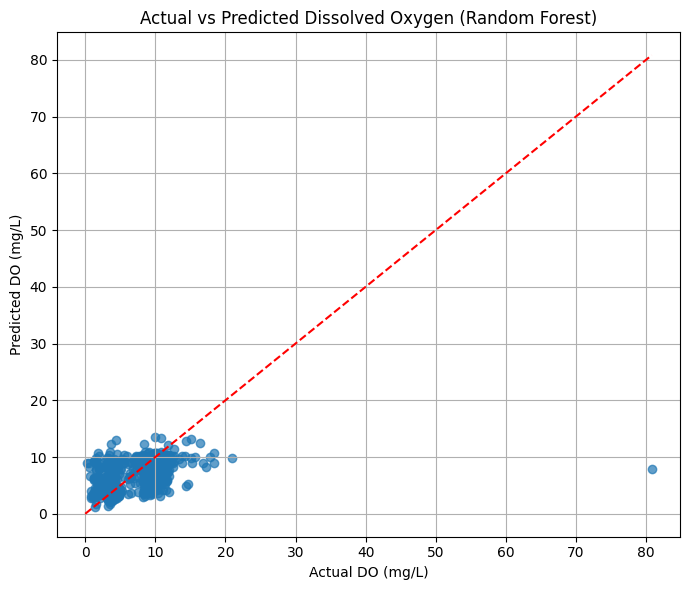

Results saved to DO_Predicted_vs_Actual.csv


In [9]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# 1️⃣ Load your dataset
df = pd.read_csv("pond_data_interpolated_with_indices (1).csv")

# 2️⃣ Make sure DO column is numeric
df["Dissolved Oxygen (mg/L)"] = pd.to_numeric(df["Dissolved Oxygen (mg/L)"], errors='coerce')

# 3️⃣ Remove Date columns (not used for modeling)
df = df.drop(columns=[c for c in df.columns if 'date' in c.lower()])

# 4️⃣ Select feature columns (avoid using DO itself)
feature_cols = [c for c in df.columns if c.startswith("band_") or c in ["pH", "temperature", "turbidity", "EC", "Ammonia (mg/L)"]]

X = df[feature_cols]
y = df["Dissolved Oxygen (mg/L)"]

# 5️⃣ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6️⃣ Train Random Forest model
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# 7️⃣ Predict DO values on test set
y_pred = rf.predict(X_test)

# 8️⃣ Evaluate model performance
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

# 9️⃣ Comparison Table
comparison_df = pd.DataFrame({
    "Actual_DO": y_test.values,
    "Predicted_DO": y_pred
})

print("\nSample Comparison:")
print(comparison_df.head(10))

# 🔟 Scatter Plot (Actual vs Predicted DO)
plt.figure(figsize=(7,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # 1:1 Reference Line
plt.xlabel("Actual DO (mg/L)")
plt.ylabel("Predicted DO (mg/L)")
plt.title("Actual vs Predicted Dissolved Oxygen (Random Forest)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 1️⃣1️⃣ Save comparison results (Optional)
comparison_df.to_csv("DO_Predicted_vs_Actual.csv", index=False)
print("Results saved to DO_Predicted_vs_Actual.csv")



Model Performance for DO
R² Score: 0.492
RMSE: 2.991
MAE: 1.343

Model Performance for Ammonia
R² Score: -0.526
RMSE: 0.136
MAE: 0.048

Model Performance for pH
R² Score: 0.501
RMSE: 0.209
MAE: 0.138


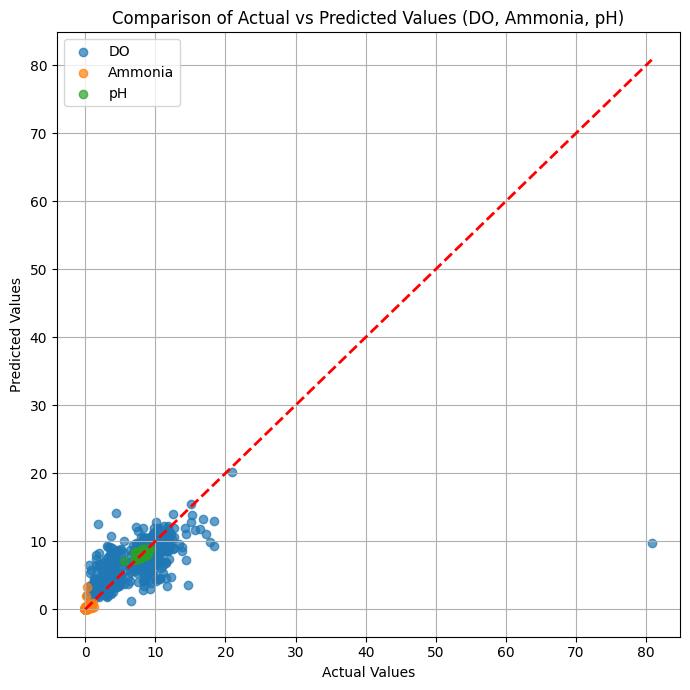

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 1️⃣ Load dataset
df = pd.read_csv("pond_data_interpolated_with_indices (1).csv")

# 2️⃣ Convert targets to numeric
for col in ["Dissolved Oxygen (mg/L)", "Ammonia (mg/L)", "pH"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 3️⃣ Keep only numeric columns
df_numeric = df.select_dtypes(include=[np.number])

# 4️⃣ Define targets
targets = {
    "Dissolved Oxygen (mg/L)": "DO",
    "Ammonia (mg/L)": "Ammonia",
    "pH": "pH"
}

# For storing predicted vs actual
combined_results = pd.DataFrame()

# 5️⃣ Loop and train models
for target_col, label in targets.items():

    temp = df_numeric.dropna(subset=[target_col])

    X = temp.drop(columns=[target_col])
    y = temp[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=200, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Store results
    combined_results[f"Actual_{label}"] = y_test.values
    combined_results[f"Predicted_{label}"] = y_pred

    # Print metrics
    print("\n============================")
    print(f"Model Performance for {label}")
    print("============================")
    print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")

# 6️⃣ Plot ALL comparisons on ONE Graph
plt.figure(figsize=(7,7))

plt.scatter(combined_results["Actual_DO"], combined_results["Predicted_DO"], label="DO", alpha=0.7)
plt.scatter(combined_results["Actual_Ammonia"], combined_results["Predicted_Ammonia"], label="Ammonia", alpha=0.7)
plt.scatter(combined_results["Actual_pH"], combined_results["Predicted_pH"], label="pH", alpha=0.7)

# 1:1 Reference Line
min_val = min(combined_results.min())
max_val = max(combined_results.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Comparison of Actual vs Predicted Values (DO, Ammonia, pH)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

